In [11]:
%pip install yellowbrick

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 735.6 kB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [30]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt; plt.style.use('dark_background')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from time import time
import shap
from sklearn import tree
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA


In [6]:
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", 
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
             "srv_diff_host_rate", "dst_host_count","dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
kdd_data_corrected = pd.read_csv("corrected.csv", header=None, names = col_names)

#Converting all the new attack labels to 'attack.'
labels = kdd_data_corrected['label'].copy()
labels[labels != 'normal.'] = 'attack.'
labels.value_counts()

label
attack.    250436
normal.     60593
Name: count, dtype: int64

In [7]:
num_features = ["duration", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
kdd_data_corrected = kdd_data_corrected[num_features].astype(float)
kdd_data_corrected.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000029,0.000762,0.000051,0.014677,0.002363,0.172476,0.011243,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.005379,0.040367,0.009821,0.312068,0.049990,0.377794,1.958325,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Assuming 'kdd_data_corrected' is your DataFrame and 'num_features' is the list of numerical feature columns
scaler = MinMaxScaler()

# Apply Min-Max scaling to all numerical feature columns
scaled_features = scaler.fit_transform(kdd_data_corrected[num_features])

# Create a new DataFrame with the scaled values
scaled_features_df = pd.DataFrame(scaled_features, columns=num_features)

# If you want to keep the scaled data in the original DataFrame
kdd_data_corrected[num_features] = scaled_features_df

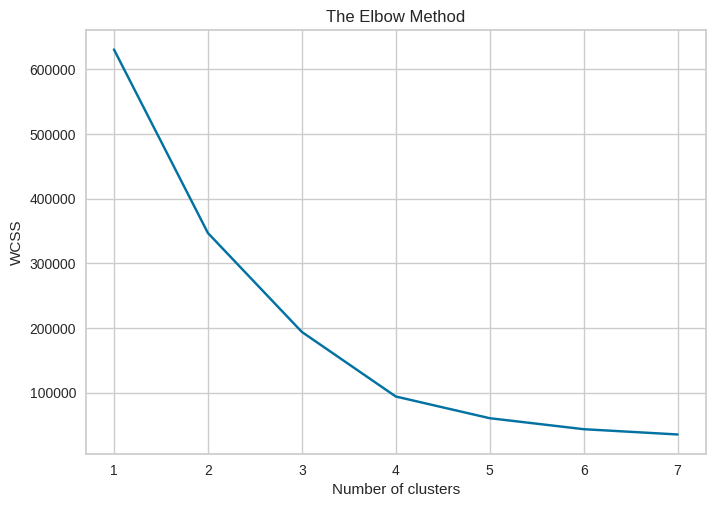

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


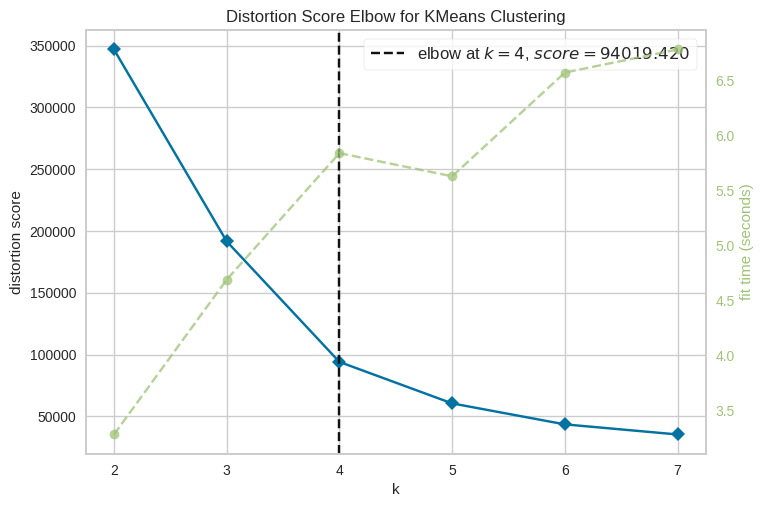

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
wcss = []
for i in range(1, 8):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42, n_init = 'auto')
    kmeans.fit(scaled_features_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 8), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

model = KMeans(init = 'k-means++', random_state = 42, n_init = 'auto')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,8), timings= True)
visualizer.fit(scaled_features_df)        # Fit data to visualizer
visualizer.show()    

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init = 'auto')
prediction = kmeans.fit_predict(scaled_features_df)
scaled_features_df['cluster'] = prediction
scaled_features_df.reset_index(drop=True, inplace=True)

In [22]:
from sklearn.metrics import silhouette_score

score = silhouette_score(scaled_features_df, scaled_features_df["cluster"], metric='euclidean')
print(score)  # Value between -1 and 1, 1 = perfect

0.7752091954693379


Text(0.5, 0.92, '3D PCA Plot of K-Means Clusters')

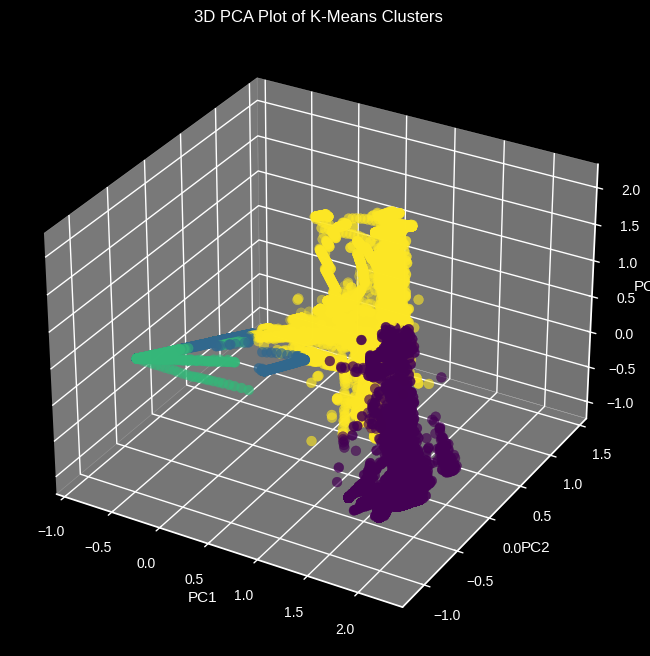

In [31]:
# Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_features_df[num_features])

# Create a DataFrame with the PCA results
pca_df_result = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df_result['cluster'] = scaled_features_df['cluster']

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df_result['PC1'], pca_df_result['PC2'], pca_df_result['PC3'], c=pca_df_result['cluster'],
                     cmap='viridis', s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Plot of K-Means Clusters')

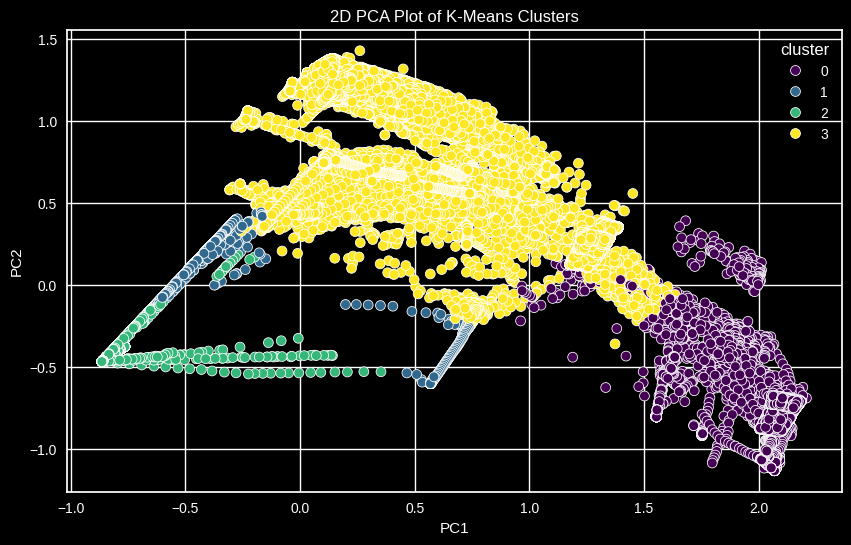

In [33]:
# Select features for PCA
pca_df = scaled_features_df[num_features]

# Standardize the data
#scaler = StandardScaler()
#scaled_data = scaler.fit_transform(pca_df)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_df)

# Create a DataFrame with the PCA results
pca_df_result = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df_result['cluster'] = scaled_features_df['cluster']

# Plot 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_result, x='PC1', y='PC2', hue='cluster', palette='viridis', s=50)
plt.title('2D PCA Plot of K-Means Clusters')
plt.show()

In [34]:
pca_df_result["cluster"].value_counts()

cluster
2    131966
3    102064
0     43945
1     33054
Name: count, dtype: int64

In [37]:
# Overall level summary
df_profile_overall = scaled_features_df.describe().T

# using median instead of mean; use appropriate summarization (mean, count, etc.) for each feature
df_profile_overall['Overall Dataset'] = df_profile_overall[['mean']]  # Use '50%' for median
df_profile_overall = df_profile_overall[['Overall Dataset']]

# Cluster ID level summary
df_cluster_summary = scaled_features_df.groupby('cluster').describe().T.reset_index()
df_cluster_summary = df_cluster_summary.rename(columns={'level_0': 'column', 'level_1': 'metric'})

# using median instead of mean; use appropriate summarization (mean, count, etc.) for each feature
df_cluster_summary = df_cluster_summary[df_cluster_summary['metric'] == 'mean']  # Use '50%' for median
df_cluster_summary = df_cluster_summary.set_index('column')

# join into a single summary dataset
df_profile = df_cluster_summary.join(df_profile_overall)  # joins on Index

In [38]:
# Print the customer profiles
df_profile

,metric,0,1,2,3,Overall Dataset
column,,,,,,
duration,mean,4.021195e-05,0.000000e+00,0.000000e+00,0.000928,0.000310
src_bytes,mean,8.010509e-09,1.626062e-05,1.295656e-05,0.000062,0.000028
dst_bytes,mean,4.991391e-07,4.248605e-08,5.024156e-08,0.000438,0.000144
land,mean,0.000000e+00,0.000000e+00,0.000000e+00,0.000088,0.000029
wrong_fragment,mean,0.000000e+00,0.000000e+00,0.000000e+00,0.000774,0.000254
urgent,mean,0.000000e+00,0.000000e+00,0.000000e+00,0.000052,0.000017
hot,mean,0.000000e+00,0.000000e+00,0.000000e+00,0.000443,0.000145
num_failed_logins,mean,9.671180e-05,0.000000e+00,0.000000e+00,0.001759,0.000591
logged_in,mean,3.208556e-03,0.000000e+00,0.000000e+00,0.524220,0.172476


In [3]:
test_number = 0.999995123
rounded_number = round(test_number, 6)
print(rounded_number)

0.999995
